In [ ]:
# notebook to use RMG's SimpleReactor to ignite the fuel and compute fast sensitivity

In [27]:
import rmgpy.chemkin
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rmgpy.solver.simple
import copy
import rmgpy.quantity
import rmgpy.rmg.settings

import importlib

import quicksim

import concurrent.futures
import subprocess


importlib.reload(quicksim)
%matplotlib inline

In [25]:
# load a mechanism
chemkin = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
mech_dir = os.path.dirname(chemkin)
species_dict = os.path.join(mech_dir, 'species_dictionary.txt')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, species_dict)


In [3]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

i_butane = get_i_thing(rmgpy.species.Species(smiles='CCCC'), species_list)
i_O2 = get_i_thing(rmgpy.species.Species(smiles='[O][O]'), species_list)
i_Ar = get_i_thing(rmgpy.species.Species(smiles='[Ar]'), species_list)
i_OH = get_i_thing(rmgpy.species.Species(smiles='[OH]'), species_list)

assert i_butane >= 0
assert i_O2 >= 0
assert i_Ar >= 0
assert i_OH >= 0

# Run a sample simulation to check things are in order

In [4]:
%%time
X = {
    species_list[i_butane]: 0.03135,
    species_list[i_Ar]: 0.7649,
    species_list[i_O2]: 0.2038,
}
mysim = quicksim.run_simulation(species_list, reaction_list, T=830, P=1013250, X=X, total_time=10.0)
delay = quicksim.get_ignition_delay(mysim, i_OH)

CPU times: user 950 ms, sys: 9.05 ms, total: 959 ms
Wall time: 957 ms


Text(0.5, 1.0, 'Linear')

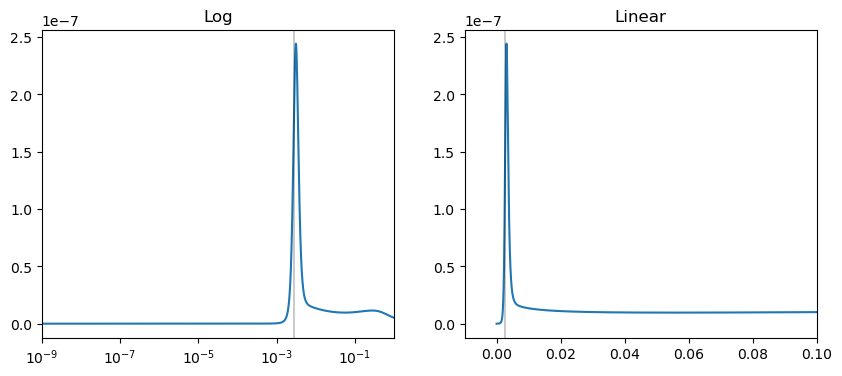

In [5]:
times = [snapshot[0] for snapshot in mysim.snapshots]
# volumes = [snapshot[1] for snapshot in mysim.snapshots]
OHs = [snapshot[2 + i_OH] for snapshot in mysim.snapshots]

fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(10)
axs[0].plot(times, OHs)
axs[0].set_xlim([1e-9, 1.0])
axs[0].set_xscale('log')
axs[0].axvline(x=delay, color='k', linewidth=0.3)
axs[0].set_title('Log')

axs[1].plot(times, OHs)
axs[1].set_xlim([-.01, 1e-1])
axs[1].axvline(x=delay, color='k', linewidth=0.3)
axs[1].set_title('Linear')

In [9]:
# do the species sensitivities

temperatures = np.linspace(663, 1077, 11)
def simulate_and_delay(condition_index):
    species_list2 = [sp for sp in species_list]
    reaction_list2 = [rxn for rxn in reaction_list]
    
    X2 = {
        species_list2[i_butane]: 0.03135,
        species_list2[i_Ar]: 0.7649,
        species_list2[i_O2]: 0.2038,
    }
    
    mysim = quicksim.run_simulation(species_list2, reaction_list2, T=temperatures[condition_index], P=1013250, X=X2, total_time=10.0)
    delay = quicksim.get_ignition_delay(mysim, i_OH)
    return delay

# Run baseline

In [16]:
# make a working_dir
working_dir = os.path.join(mech_dir, 'fast_sens')
os.makedirs(working_dir, exist_ok=True)

In [18]:
%%time
condition_indices = np.arange(len(temperatures))
delays = np.zeros_like(temperatures)
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(
        simulate_and_delay,
        [j for j in condition_indices]
    )):
        delays[condition_index] = delay_time
base_delayfile = os.path.join(working_dir, 'base_delay.npy')
np.save(base_delayfile, delays)

CPU times: user 39.6 ms, sys: 130 ms, total: 169 ms
Wall time: 4.63 s


Text(0, 0.5, 'Delay (s)')

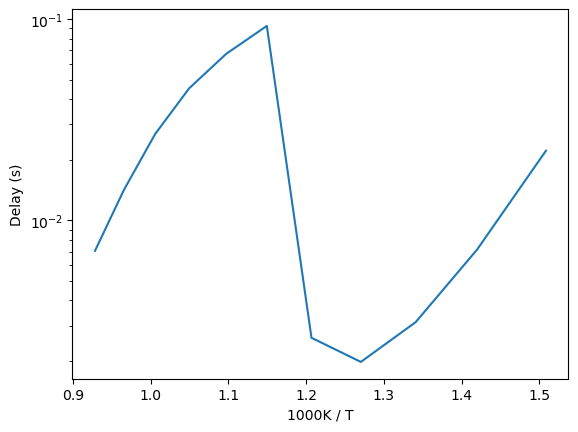

In [14]:
plt.plot(1000.0 / temperatures, delays)
plt.yscale('log')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')

# Run all species sensitivities

In [23]:
DELTA_J_MOL = 418.4  # J/mol, but equals 0.1 kcal/mol
R = 8.3144598  # gas constant in J/mol

def perturb_species(species):
    # takes in an RMG species object
    # change the enthalpy offset
    increase = None
    for poly in species.thermo.polynomials:
        new_coeffs = poly.coeffs
        if not increase:
            # Only define the increase in enthalpy once or you'll end up with numerical gaps in continuity
            # increase = DELTA * new_coeffs[5]
            increase = DELTA_J_MOL / R
        new_coeffs[5] += increase
        poly.coeffs = new_coeffs


In [26]:
condition_indices = np.arange(len(temperatures))
for i in range(len(species_list)):

    # perturb species
    orig_species = copy.deepcopy(species_list[i].thermo)
    perturb_species(species_list[i])
    
    delays = np.zeros_like(temperatures)
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        for condition_index, delay_time in zip(condition_indices, executor.map(
            simulate_and_delay,
            [j for j in condition_indices]
        )):
            delays[condition_index] = delay_time
            
    # reset to normal
    species_list[i].thermo = orig_species
    
    sp_delayfile = os.path.join(working_dir, f'species_{i:04}.npy')
    np.save(sp_delayfile, delays)

In [30]:
# compile spec results
base_delays = np.load(base_delayfile)
spec_delays = np.zeros((len(species_list), len(temperatures)))
spec_sens = np.zeros_like(spec_delays)
for i in range(len(species_list)):
    sp_delayfile = os.path.join(working_dir, f'species_{i:04}.npy')
    spec_delays[i, :] = np.load(sp_delayfile)
    spec_sens[i, :] = spec_delays[i, :] - base_delays
spec_sens[np.isnan(spec_sens)] = 0

In [35]:
indices = np.arange(len(species_list))
sorted_order = [x for _,x in sorted(zip(np.abs(spec_sens[:, 0]), indices))][::-1]
for i in range(10):
    print(species_list[sorted_order[i]])


S(229)
O2(2)
[CH2]CC(C)OO(108)
S(186)
HO2(16)
S(225)
C4H8(188)
butane(1)
C4H8(189)
S(184)


In [38]:
DELTA = 0.01
def perturb_reaction(rxn):
    # takes in an RMG reaction object
    # delta is the ln(k) amount to perturb the A factor
    # delta is a multiplicative factor- units don't matter, yay!
    # does not deepycopy because there's some issues with rmgpy.reactions copying
    if type(rxn.kinetics) == rmgpy.kinetics.chebyshev.Chebyshev:
        rxn.kinetics.coeffs.value_si[0][0] += np.log10(1.0 + DELTA)
    elif type(rxn.kinetics) in [rmgpy.kinetics.falloff.Troe, rmgpy.kinetics.falloff.ThirdBody, rmgpy.kinetics.falloff.Lindemann]:
        if hasattr(rxn.kinetics, 'arrheniusHigh'):
            rxn.kinetics.arrheniusHigh.A.value *= np.exp(DELTA)
        if hasattr(rxn.kinetics, 'arrheniusLow'):
            rxn.kinetics.arrheniusLow.A.value *= np.exp(DELTA)
    elif type(rxn.kinetics) == rmgpy.kinetics.arrhenius.MultiArrhenius:
        for j in range(len(rxn.kinetics.arrhenius)):
            rxn.kinetics.arrhenius[j].A.value *= np.exp(DELTA)
    elif type(rxn.kinetics) == rmgpy.kinetics.arrhenius.PDepArrhenius:
        for j in range(len(rxn.kinetics.arrhenius)):
            if type(rxn.kinetics.arrhenius[j]) == rmgpy.kinetics.arrhenius.Arrhenius:
                rxn.kinetics.arrhenius[j].A.value *= np.exp(DELTA)
            elif type(rxn.kinetics.arrhenius[j]) == rmgpy.kinetics.arrhenius.MultiArrhenius:
                for k in range(len(rxn.kinetics.arrhenius[j].arrhenius)):
                    rxn.kinetics.arrhenius[j].arrhenius[k].A.value *= np.exp(DELTA)
            else:
                raise ValueError(f'weird kinetics {str(rxn.kinetics)}')
    elif type(rxn.kinetics) == rmgpy.kinetics.arrhenius.MultiPDepArrhenius:
        for i in range(len(rxn.kinetics.arrhenius)):
            for j in range(len(rxn.kinetics.arrhenius[i].arrhenius)):
                if type(rxn.kinetics.arrhenius[i].arrhenius[j]) == rmgpy.kinetics.arrhenius.Arrhenius:
                    rxn.kinetics.arrhenius[i].arrhenius[j].A.value *= np.exp(DELTA)
                elif type(rxn.kinetics.arrhenius[i].arrhenius[j]) == rmgpy.kinetics.arrhenius.MultiArrhenius:
                    for k in range(len(rxn.kinetics.arrhenius[i].arrhenius[j].arrhenius)):
                        rxn.kinetics.arrhenius[i].arrhenius[j].arrhenius[k].A.value *= np.exp(DELTA)
                else:
                    raise ValueError(f'weird kinetics {str(rxn.kinetics)}')

    else:  # Arrhenius
        rxn.kinetics.A.value *= np.exp(DELTA)

In [43]:
rxn_index_start = 100
REACTIONS_PER_FILE = 10
output_reaction_delays_file = os.path.join(working_dir, f'reaction_delays_{rxn_index_start:04}.npy')


reaction_delays = np.zeros((len(reaction_list), len(temperatures)))

for i in range(rxn_index_start, min(rxn_index_start + REACTIONS_PER_FILE, len(reaction_list))):
    # perturb reaction
    orig_reaction = copy.deepcopy(reaction_list[i].kinetics)
    perturb_reaction(reaction_list[i])
    
    delays = np.zeros_like(temperatures)
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        for condition_index, delay_time in zip(condition_indices, executor.map(
            simulate_and_delay,
            [j for j in condition_indices]
        )):
            delays[condition_index] = delay_time
            
    # reset to normal
    reaction_list[i].kinetics = orig_reaction
    
    reaction_delays[i, :] = delays


# save the result as a numpy thing
np.save(output_reaction_delays_file, reaction_delays)

In [44]:
# compile rxn results
base_delays = np.load(base_delayfile)
rxn_delays = np.zeros((len(reaction_list), len(temperatures)))
rxn_sens = np.zeros_like(rxn_delays)

for i in range(int(len(reaction_list) / REACTIONS_PER_FILE)):
    rxn_delayfile = os.path.join(working_dir, f'reaction_delays_{i * REACTIONS_PER_FILE:04}.npy')
    if not os.path.exists(rxn_delayfile):
        continue
    rxn_delays += np.load(rxn_delayfile)
for i in range(len(reaction_list)):
    if np.all(rxn_delays[i, :] == 0):
        continue
    rxn_sens[i, :] = rxn_delays[i, :] - base_delays
rxn_sens[np.isnan(rxn_sens)] = 0

In [45]:
indices = np.arange(len(reaction_list))
sorted_order = [x for _,x in sorted(zip(np.abs(rxn_sens[:, 0]), indices))][::-1]
for i in range(10):
    print(reaction_list[sorted_order[i]])


O2(2) + SC4H9(183) <=> HO2(16) + C4H8(189)
O2(2) + SC4H9(183) <=> S(186)
O2(2) + C2H5(33) <=> C2H5O2(47)
C2H4(11) + C2H5(33) <=> PC4H9(182)
O2(2) + C2H5(33) <=> HO2(16) + C2H4(11)
CH3(18) + C3H6(12) <=> PC4H9(182)
O2(2) + H(14) <=> O(5) + OH(15)
O(5) + O(5) <=> O2(2)
Ar + O(5) + O(5) <=> Ar + O2(2)
O(5) + H2(13) <=> H(14) + OH(15)


In [51]:
reaction_list[sorted_order[2]]

In [11]:
%%time

delays = np.zeros_like(temperatures)
for i in range(len(temperatures)):
    mysim = quicksim.run_simulation(species_list, reaction_list, T=temperatures[i], P=1013250, X=X, total_time=10.0)
    delays[i] = quicksim.get_ignition_delay(mysim, i_OH)

CPU times: user 10.2 s, sys: 38.1 ms, total: 10.2 s
Wall time: 10.2 s


In [ ]:
plt.plot(1000.0 / temperatures, delays)
plt.yscale('log')

In [ ]:
%%time
# quicksim.run_simulation(species_list, reaction_list, T=1000, P=1013250, total_time=10.0)
P = 1013250
total_time = 10.0
condition_indices = np.arange(len(temperatures))
delays = np.zeros_like(temperatures)
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(
        simulate_and_delay,
        [j for j in condition_indices]
    )):
        delays[condition_index] = delay_time
print(delays)

In [ ]:
plt.plot(1000.0 / temperatures, delays)
plt.yscale('log')